# ⚙️ Ustawienia ⬇️

In [161]:
# ścieżka do pliku nawigacyjnego
nav_file = r'C:\SEM4\SNS\Projekt2\WROC00POL_R_20220800000_01D_GN.rnx'
# ścieżka do pliku obserwacyjnego
obs_file = r'C:\SEM4\SNS\Projekt2\WROC00POL_R_20220800000_01D_30S_MO.rnx'
# ścieżka docelowa pliku do zapisanymi współrzędnymi
coords_file = r'C:\SEM4\SNS\Projekt2\wyniki_wspolrzedne.txt'
# ścieżka docelowa pliku do zapisanymi współrzędnymi
differences_file = r'C:\SEM4\SNS\Projekt2\wyniki_bledy.txt'

# zdefiniowanie czasu obserwacji: daty początkowej i końcowej
time_start = [2022, 3, 21, 0, 0, 0]
time_end = [2022, 3, 21, 23, 59, 59]

# maska obserwacji [stopnie]
el_mask = 10

# czy użyć poprawki troposferycznej w obliczeniach? ('Y' lub 'N') yes / no
# model sastamoinena
TROPO = 'Y'
# czy użyć poprawki jonosferycznej w obliczeniach? ('Y' lub 'N') yes / no
IONO = 'Y'

# wybór obseracji - ['C1C'] lub  ['C2W']
obs_list = ['C1C']

# Program

In [162]:
import pandas as  pd
import numpy as np
import seaborn as sns
from datetime import date
from math import *
from poprawka_toposferyczna import md, mw, poprawka_toposferyczna
from klobuchar1 import klobuchar
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')
sns.set_theme(context='talk', style='darkgrid')


def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = B - A
    return rotation_matrix.transpose() @ vector


def Hirvonen(x, y, z, a=6378137, e2=0.00669437999013):
    """zwraca współrzędne fi, lambda, h. Algorytm Hirvonena"""
    #     epsilon = 0.00005/3600  # epsilon w stopniach dziesiętnych
    # Krasowski - a=6378245, e2=0.0066934215520398155
    # GRS80 - a=6378137, e2=0.00669437999013
    r = sqrt(x**2 + y**2)
    phi_old = atan((z / r) * (1 - e2)**(-1))
    while True:
        N = a / (sqrt(1 - e2 * (sin(phi_old))**2))
        h = (r / cos(phi_old)) - N
        phi_new = atan((z / r) * (1 - e2 * (N / (N + h)))**(-1))
        if abs(phi_new - phi_old) < radians(0.00005 / 3600):
            break
        else:
            phi_old = phi_new
    lam = np.arctan2(y, x)  # lam = atan(y / x)
    N = a / (sqrt(1 - e2 * (sin(phi_new))**2))
    h = (r / cos(phi_new)) - N
    return degrees(phi_new), degrees(lam), h


def readrnxnav(file):
    m = 1
    nav = np.zeros((2000, 37))
    inav = np.zeros((2000))
    n = -1
    with open(file, "r") as f:
        for s in f:
            answer = s.find('END OF HEADER')  # skip header
            if answer != -1:
                break
        for s in f:
            s = s.replace('D', 'E')
            if m == 1:
                prn = int(s2n(s, 1, 2))
                a = np.empty((1, 6))
                a[:] = np.NaN
                a[0, 0:6] = np.array(s2e(s, 4, 23))
            else:
                a = np.append(a, s2n(s, 4, 19))
            for x in range(3):
                p = 23+x*19
                a = np.append(a, s2n(s, p, 19))
            if m < 8:
                m += 1
            else:
                n += 1
                nav[n, :] = a
                inav[n] = prn
                m = 1
        nav = nav[0:n+1, :]
        inav = inav[0:n+1]
        inav = inav.astype(int)
    f.close()
    return nav, inav


def readrnxobs(file, time_start, time_end, GNSS='G'):
    with open(file, "r") as f:
        for s in f:
            label = s[59:]
            if label.find('SYS / # / OBS TYPES') == 1:
                if s[0] == GNSS:
                    p = 7
                    types_header = []
                    for i in range(int(s[4:4+2])):
                        if p > 58:
                            p = 7
                            s = next(f)
                        types_header.append(s[p:p+3])
                        p += 4

            elif label.find('APPROX POSITION XYZ') != -1:
                xr = np.array(
                    ([float(s[1:1+14]), float(s[15:15+14]), float(s[29:29+14])]))
            elif label.find('END OF HEADER') == 1:
                break
            types_of_obs = obs_list  # lista, można podać inne obs np ,'C2W'
        ind = np.zeros((len(types_header)))
        for n in range(len(types_of_obs)):
            i = (types_header.index(
                types_of_obs[n])) if types_of_obs[n] in types_header else -1  # np.empty((0))
            if i > -1:
                ind[i] = n+1
        obs = np.zeros((150000, len(types_of_obs)))*np.nan
        iobs = np.zeros((150000, 3))
        n = 0
        for s in f:
            label = s[0]
            if label == '>':
                epoch = s2e(s, 2, 29)
                y = epoch[0]
                # tt = (date.toordinal(date(epoch[0],epoch[1],epoch[2]))+366-t0)*86400+np.dot((epoch[3:6]), ([3600,60,1])) + 6*86400
                tt = date2tow(epoch)[1] - date2tow(epoch)[2] * 86400
                if tt > (date2tow(time_end)[1] - date2tow(epoch)[2] * 86400):
                    break
                else:
                    flag = int(round(tt)) >= (date2tow(time_start)[
                        1] - date2tow(time_start)[2] * 86400)
                if flag:
                    number_of_all_sats = int(s[33:33+2])
                    iobs[n+np.arange(0, number_of_all_sats), 1] = tt
                    iobs[n+np.arange(0, number_of_all_sats),
                         2] = date2tow(epoch)[1]
                    for sat in range(number_of_all_sats):
                        s = next(f)
                        p = 3
                        if s[0] == GNSS:
                            for i in range(len(types_header)):
                                if ind[i] != 0:
                                    obs[n+sat, int(ind[i] - 1)] = s2n(s, p, 16)
                                    iobs[n+sat, 0] = s2n(s, 1, 2)
                                p += 16
                    n += number_of_all_sats
        obs = obs[0:n, :]
        iobs = iobs[0:n, :]
        obs = np.delete(obs, iobs[:, 0] == 0, axis=0)
        iobs = np.delete(iobs, iobs[:, 0] == 0, axis=0)
        f.close()
        iobs = iobs.astype(int)
    return obs, iobs, xr


def s2e(s, p, n):
    epoch = [int(s[p:p+4]), int(s[p+5:p+5+2]), int(s[p+8:p+8+2]),
             int(s[p+11:p+11+2]), int(s[p+14:p+14+2]), float(s[p+17:n])]
    return epoch


def date2tow(data):
    # ktorys kwietnia 2019 w poprzedniej date2tow, tutaj liczymy od 1980 roku, wczesniej byl rollover
    dday = date.toordinal(
        date(data[0], data[1], data[2])) - (date.toordinal(date(1980, 1, 6)))
    week = dday//7
    dow = dday % 7
    tow = dow * 86400 + data[3] * 3600 + data[4] * 60 + data[5]
    return week, tow, dow


def s2n(s, p, n):
    a = s[p:p+n]
    if (not (a and not a.isspace())):
        a = np.nan
    else:
        a = float(a)
    return a


def satpos(nav, week, tow):
    mi = 3.986005e14
    omge = 7.2921151467e-5
    # parametry zegara
    toc = nav[0:5]
    toe = nav[17]
    af0 = nav[6]
    af1 = nav[7]
    af2 = nav[8]
    week = nav[27]
    # elementy orbity keplerowskiej
    sqrta = nav[16]
    e = nav[14]
    i0 = nav[21]
    Omega_zero = nav[19]
    omega = nav[23]
    M0 = nav[12]
    # parametry perturbacyjne
    delta_n = nav[11]
    Omega_dot = nav[24]
    IDOT = nav[25]
    Cuc = nav[13]
    Cus = nav[15]
    Cic = nav[18]
    Cis = nav[20]
    Crc = nav[22]
    Crs = nav[10]
    tk = tow - toe
    # print(f'{tk=}')
    a = sqrta**2
    n0 = np.sqrt(mi/(a**3))
    n = n0 + delta_n
    Mk = M0 + n * tk
    Epop = Mk
    while True:
        E = Mk + e * np.sin(Epop)
        if (abs(E-Epop) < 10**(-12)):
            break
        Epop = E
    Ek = E
    vk = np.arctan2(np.sqrt(1 - e**2)*np.sin(Ek), np.cos(Ek)-e)
    Fik = vk + omega
    duk = Cus * np.sin(2*Fik) + Cuc * np.cos(2*Fik)
    drk = Crs * np.sin(2*Fik) + Crc * np.cos(2*Fik)
    dik = Cis * np.sin(2*Fik) + Cic * np.cos(2*Fik)
    uk = Fik + duk
    rk = a*(1 - e*np.cos(Ek)) + drk
    ik = i0 + IDOT * tk + dik
    xk = rk * np.cos(uk)
    yk = rk * np.sin(uk)
    Omega_k = Omega_zero + (Omega_dot - omge) * tk - omge * toe
    Xk = xk * np.cos(Omega_k) - yk * np.cos(ik) * np.sin(Omega_k)
    Yk = xk * np.sin(Omega_k) + yk * np.cos(ik) * np.cos(Omega_k)
    Zk = yk * np.sin(ik)
    # print(f'{Xk=} {Yk=} {Zk}')  # Współrzędne satelity w układzie ECEF
    # obliczenie błędu synchronizacji zegara satelity
    delta_t_s = af0 + af1*(t-toe) + af2*(t-toe)**2
    # print(f'{delta_t_s=}')
    # obliczenie poprawki relatywistycznej i dodanie jej do delta_t_s
    c = 299792458.0
    delta_t_rel = ((-2*np.sqrt(mi))/(c**2)) * e*sqrta*np.sin(Ek)
    # print(f'{delta_t_rel=}')
    delta_tsrel = delta_t_s + delta_t_rel
    # print(f'{delta_tsrel=}')
    return(Xk, Yk, Zk, delta_tsrel)

obs, iobs, xr0 = readrnxobs(obs_file, time_start, time_end, 'G')
#print(f'{xr0=}')
nav, inav = readrnxnav(nav_file)

# wyszukiwanie niezdrowych satelitów 
def find_unhealthy(inav, nav):
    ind = nav[:, 30] != 0
    unhealthy_satellites = np.unique(inav[ind])
    return unhealthy_satellites

def clean_data(iobs, obs, unhealthy_sats):
    for sat_nr in unhealthy_sats:
        wrong = iobs[:, 0] == sat_nr
        iobs = np.delete(iobs, wrong, axis=0)
        obs = np.delete(obs, wrong, axis=0)
    ind_nan = np.isnan(obs)[:, 0]
    obs = np.delete(obs, ind_nan, axis=0)
    iobs = np.delete(iobs, ind_nan, axis=0)
    return iobs, obs

unhealthy_sats = find_unhealthy(inav, nav)
iobs, obs = clean_data(iobs, obs, unhealthy_sats)

week, tow = date2tow(time_start)[0:2]
week_end, tow_end = date2tow(time_end)[0:2]
#print(f'{week=} {tow=} {week_end=} {tow_end=}')


KONTENER = []
KONT_DX = []
KONT_DY = []
KONT_DZ = []
WSPOLRZEDNE = []
VISIBLE_SATS = []
dt = 30
omge = 7.2921151467e-5
c = 299792458.0
alfa = [1.6764e-08,  7.4506e-09, -1.1921e-07,  0.0000e+00]  # do klobuchar jono
beta = [1.1059e+05,  0.0000e+00, -2.6214e+05,  0.0000e+00]  # do klobuchar jono
for t in range(tow, tow_end+1, dt):
    ind = iobs[:, 2] == t
    Pobs = obs[ind]
    sats = iobs[ind]
    taus = dict()
    for sat in sats:
        taus[sat[0]] = 0.072
    XR = xr0
    xr, yr, zr = XR[0], XR[1], XR[2]
    dtr = 0
    for i in range(5):  # in rang 5
        A = []
        Y = []
        for j, sat in enumerate(sats):
            sat_nr = sat[0]
            tr = t - taus[sat_nr] + dtr  # rownanie 7
            ind = inav == sat_nr
            nav1 = nav[ind, :]
            tt = sat[2]
            week = nav1[:, 27][0]
            tt = tt + week *7*86400
            toe_all = nav1[:, 17] + nav1[:, 27] * 86400*7
            roznica = tt - toe_all
            ind_t = np.argmin(abs(roznica))
            nav0 = nav1[ind_t, :]
            xs0, ys0, zs0, dts = satpos(nav0, week, tr)
            xs_rot = np.array([[np.cos(omge*taus[sat_nr]), np.sin(omge*taus[sat_nr]), 0],
                               [-np.sin(omge*taus[sat_nr]),
                                np.cos(omge*taus[sat_nr]), 0],
                               [0, 0, 1]]) @ np.array([xs0, ys0, zs0])
            xs, ys, zs = xs_rot[0], xs_rot[1], xs_rot[2]
            rho = np.sqrt((xs-xr)**2 + (ys-yr)**2 + (zs-zr)**2)  # r 10
            taus[sat_nr] = rho/c
            fii, lamm, h = Hirvonen(xr, yr, zr)
            n, e, u = xyz2neu(fii, lamm, np.array(
                [xr, yr, zr]), np.array([xs, ys, zs]))
            az = np.arctan2(e, n)  # azymut
            ele = np.arcsin(u/np.sqrt(n**2 + e**2 + u**2))  # elewacja
            azst = np.rad2deg(az)
            elst = np.rad2deg(ele)
            # tutaj odrzucenie satelitow ponizej maski
            if elst < el_mask:
                continue

            if TROPO == 'Y':
                pop_topo = poprawka_toposferyczna(h_el=180, el_sat=elst)
            else:
                pop_topo = 0
            if IONO == 'Y':
                pop_jono = klobuchar(tow=t, phi=fii, lam=lamm,
                                    el=elst, az=azst, alfa=alfa, beta=beta)
            else:
                pop_jono = 0
                    
            p_calc = rho - c*dts + c*dtr + pop_topo + pop_jono

            Y.append((p_calc - Pobs[j])[0])
            A.append([-(xs-xr)/rho, -(ys-yr)/rho, -(zs-zr)/rho, 1])

        A = np.array(A)
        Y = np.array(Y)
        X = -np.linalg.inv(A.T @ A) @ (A.T @ Y)
        deltaa_xr, deltaa_yr, deltaa_zr, deltaa_dtr = X
        xr += deltaa_xr
        yr += deltaa_yr
        zr += deltaa_zr
        dtr += deltaa_dtr/c

        delta_x = xr-xr0[0]
        delta_y = yr-xr0[1]
        delta_z = zr-xr0[2]
        ROZNICE_WSP = [delta_x, delta_y, delta_z]
        if i == 4:  # ostatnia iteracja pętli in range(5)
            KONTENER.append(ROZNICE_WSP)
            WSPOLRZEDNE.append([xr, yr, zr])
            KONT_DX.append(delta_x)
            KONT_DY.append(delta_y)
            KONT_DZ.append(delta_z)
            VISIBLE_SATS.append(len(Y))


np.savetxt(coords_file,WSPOLRZEDNE)
np.savetxt(differences_file,KONTENER)

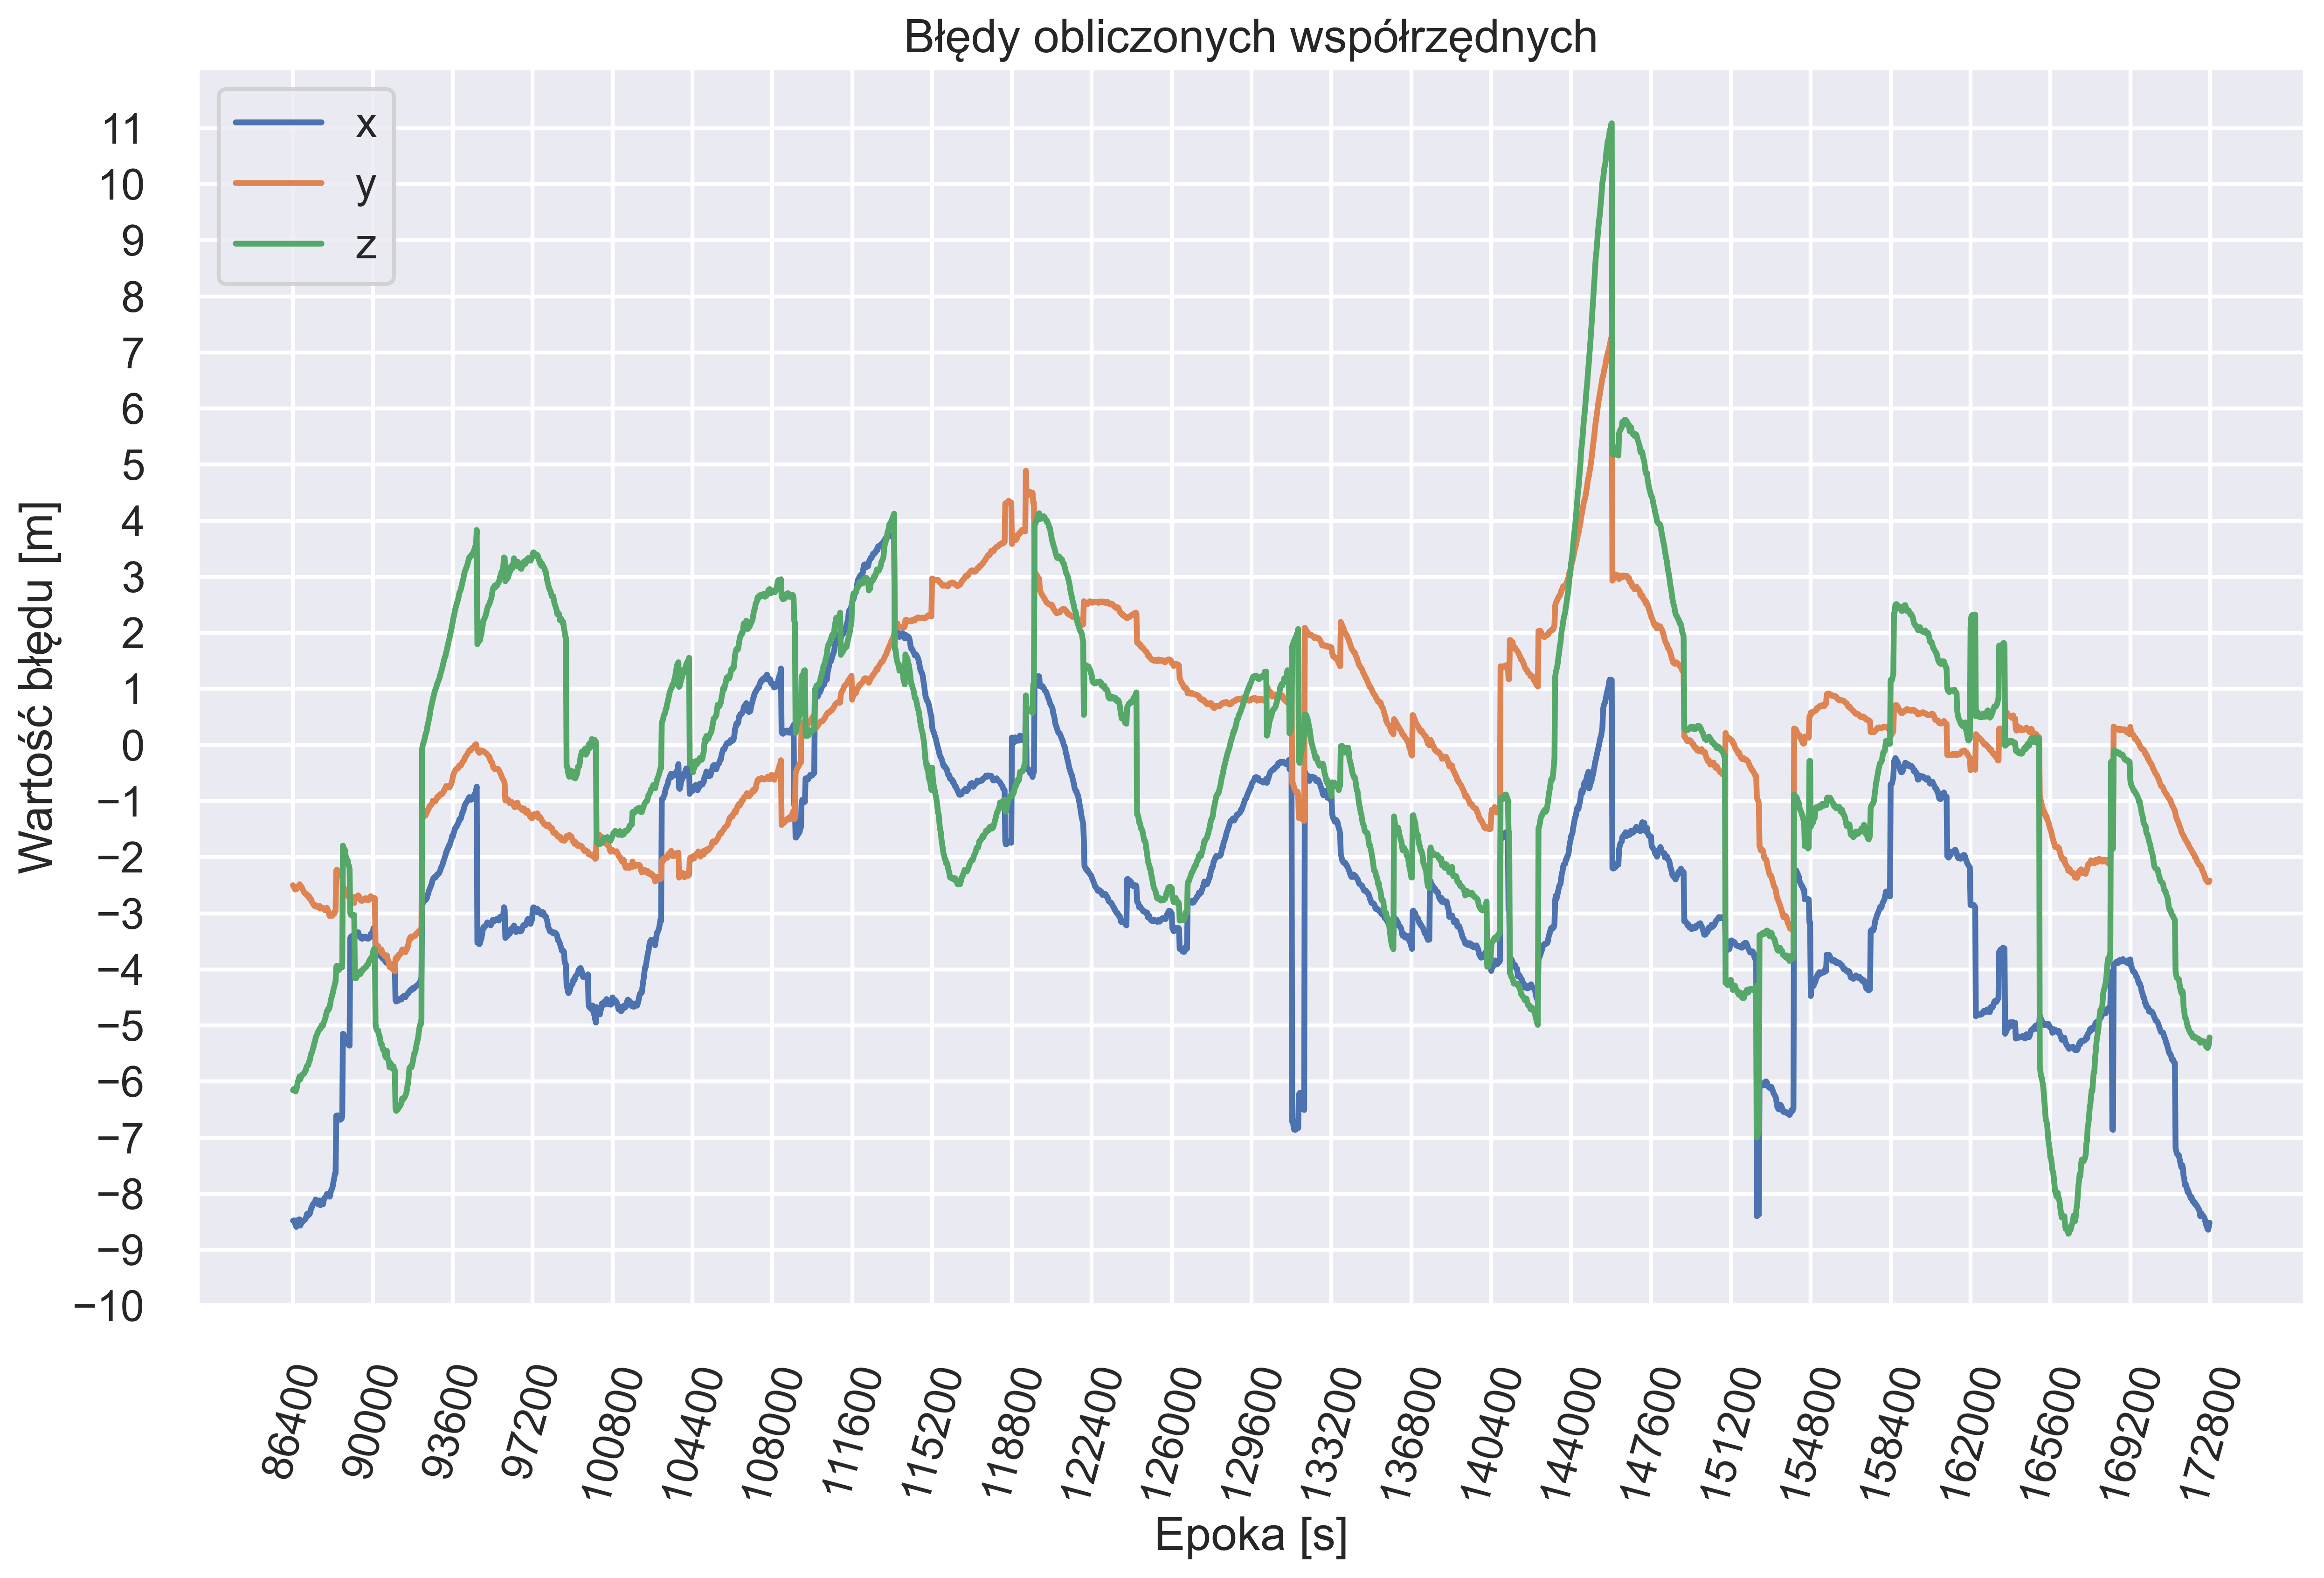

In [163]:
plt.rcParams['figure.dpi'] = 400
plt.plot(np.arange(tow, tow_end+1, dt), KONTENER, label=['x', 'y', 'z'])
plt.title('Błędy obliczonych współrzędnych')
plt.xticks(np.arange(tow,tow_end+3600,3600), rotation=75)
plt.yticks(np.arange(-10,12,1))  #
plt.xlabel('Epoka [s]')
plt.ylabel('Wartość błędu [m]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [164]:

dfdelta = pd.DataFrame({
    "dX":KONT_DX,
    "dY":KONT_DY,
    "dZ":KONT_DZ,
})

In [165]:
# dfdelta

In [166]:
# STATYSTYKI BŁĘDÓW 
dfdelta.describe()

,dX,dY,dZ
count,2880.000000,2880.000000,2880.000000
mean,-2.563251,0.194763,-0.416486
std,2.389079,1.940297,3.079484
min,-8.643153,-4.036896,-8.713609
25%,-4.017352,-1.296782,-2.219933
50%,-2.880842,0.237377,-0.239058
75%,-0.708983,1.504979,1.664938
max,3.783035,7.278744,11.086513


In [167]:
# RMSE X
# rms_x = np.sqrt(np.sum(np.array(KONT_DX)**2)/len(KONT_DX))
rmse_x = np.sqrt(np.square(np.array(KONT_DX)).mean())
rmse_x

3.50370799015052

In [168]:
# RMSE Y
rmse_y = np.sqrt(np.square(np.array(KONT_DY)).mean())
rmse_y

1.9497124280448102

In [169]:
# RMSE Z
rmse_z = np.sqrt(np.square(np.array(KONT_DZ)).mean())
rmse_z

3.106990406786988

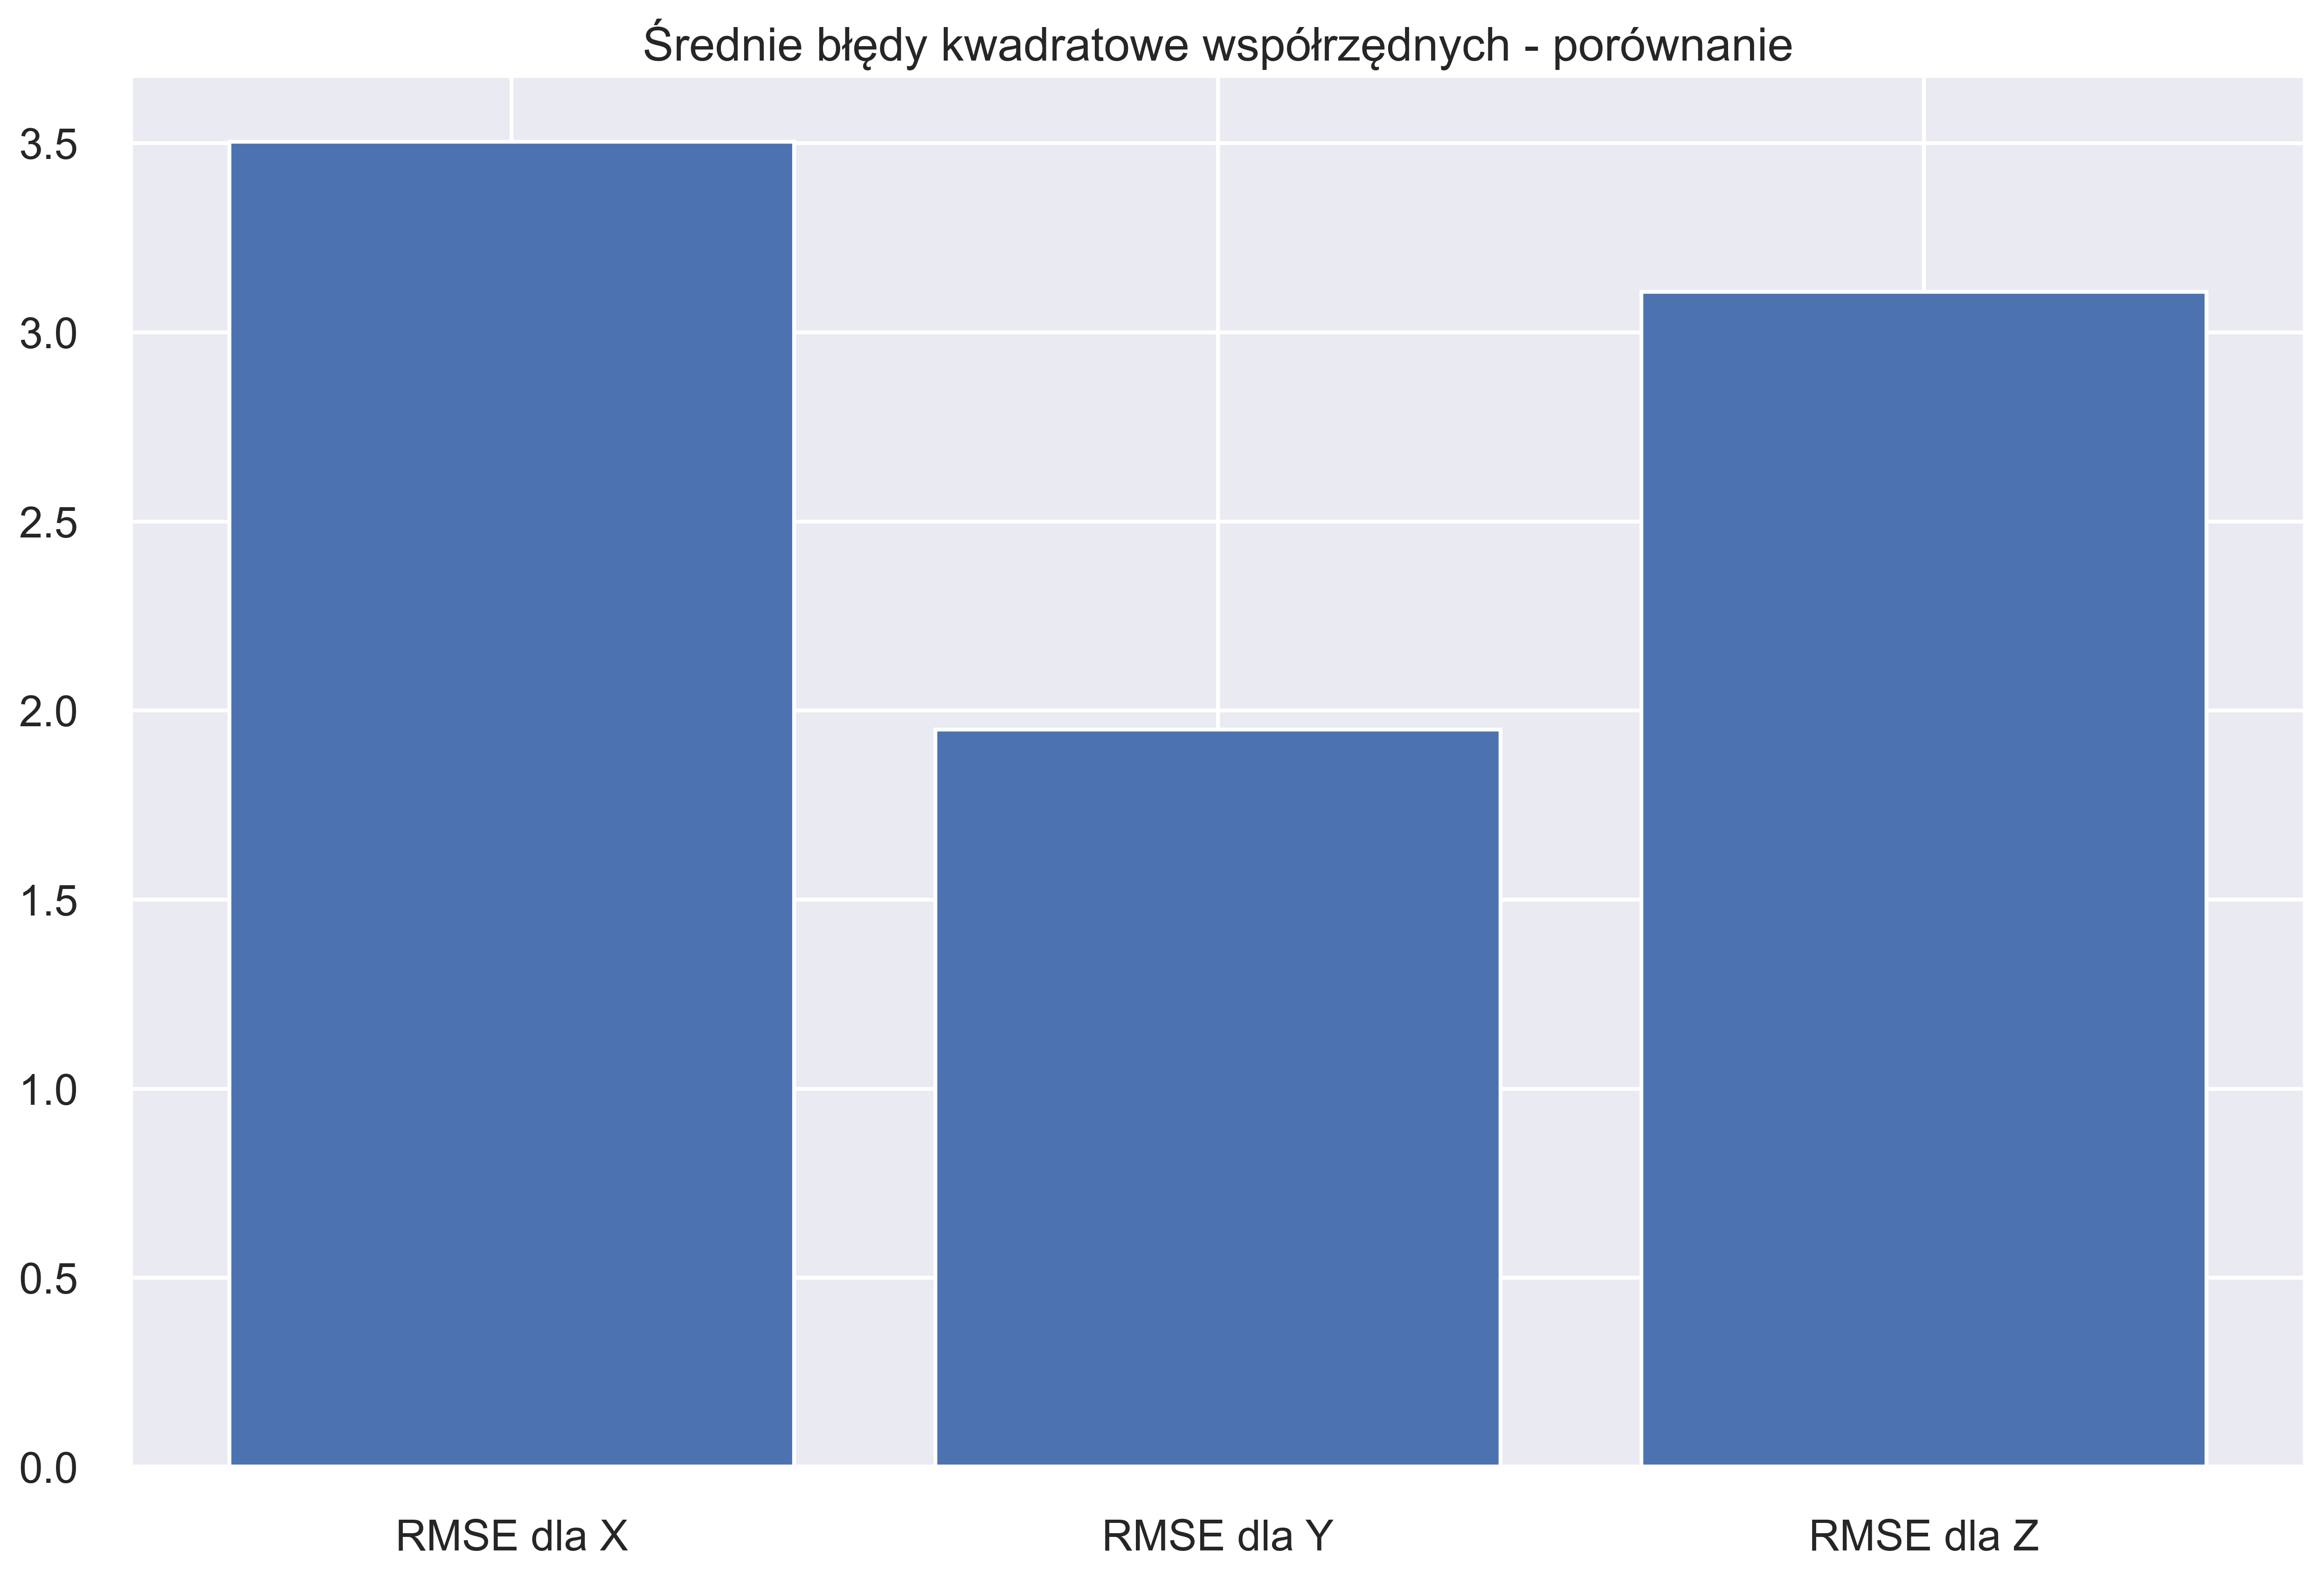

In [170]:
plt.bar(['RMSE dla X', 'RMSE dla Y', 'RMSE dla Z'], [rmse_x, rmse_y, rmse_z])
plt.title('Średnie błędy kwadratowe współrzędnych - porównanie')
plt.tight_layout()
plt.show()

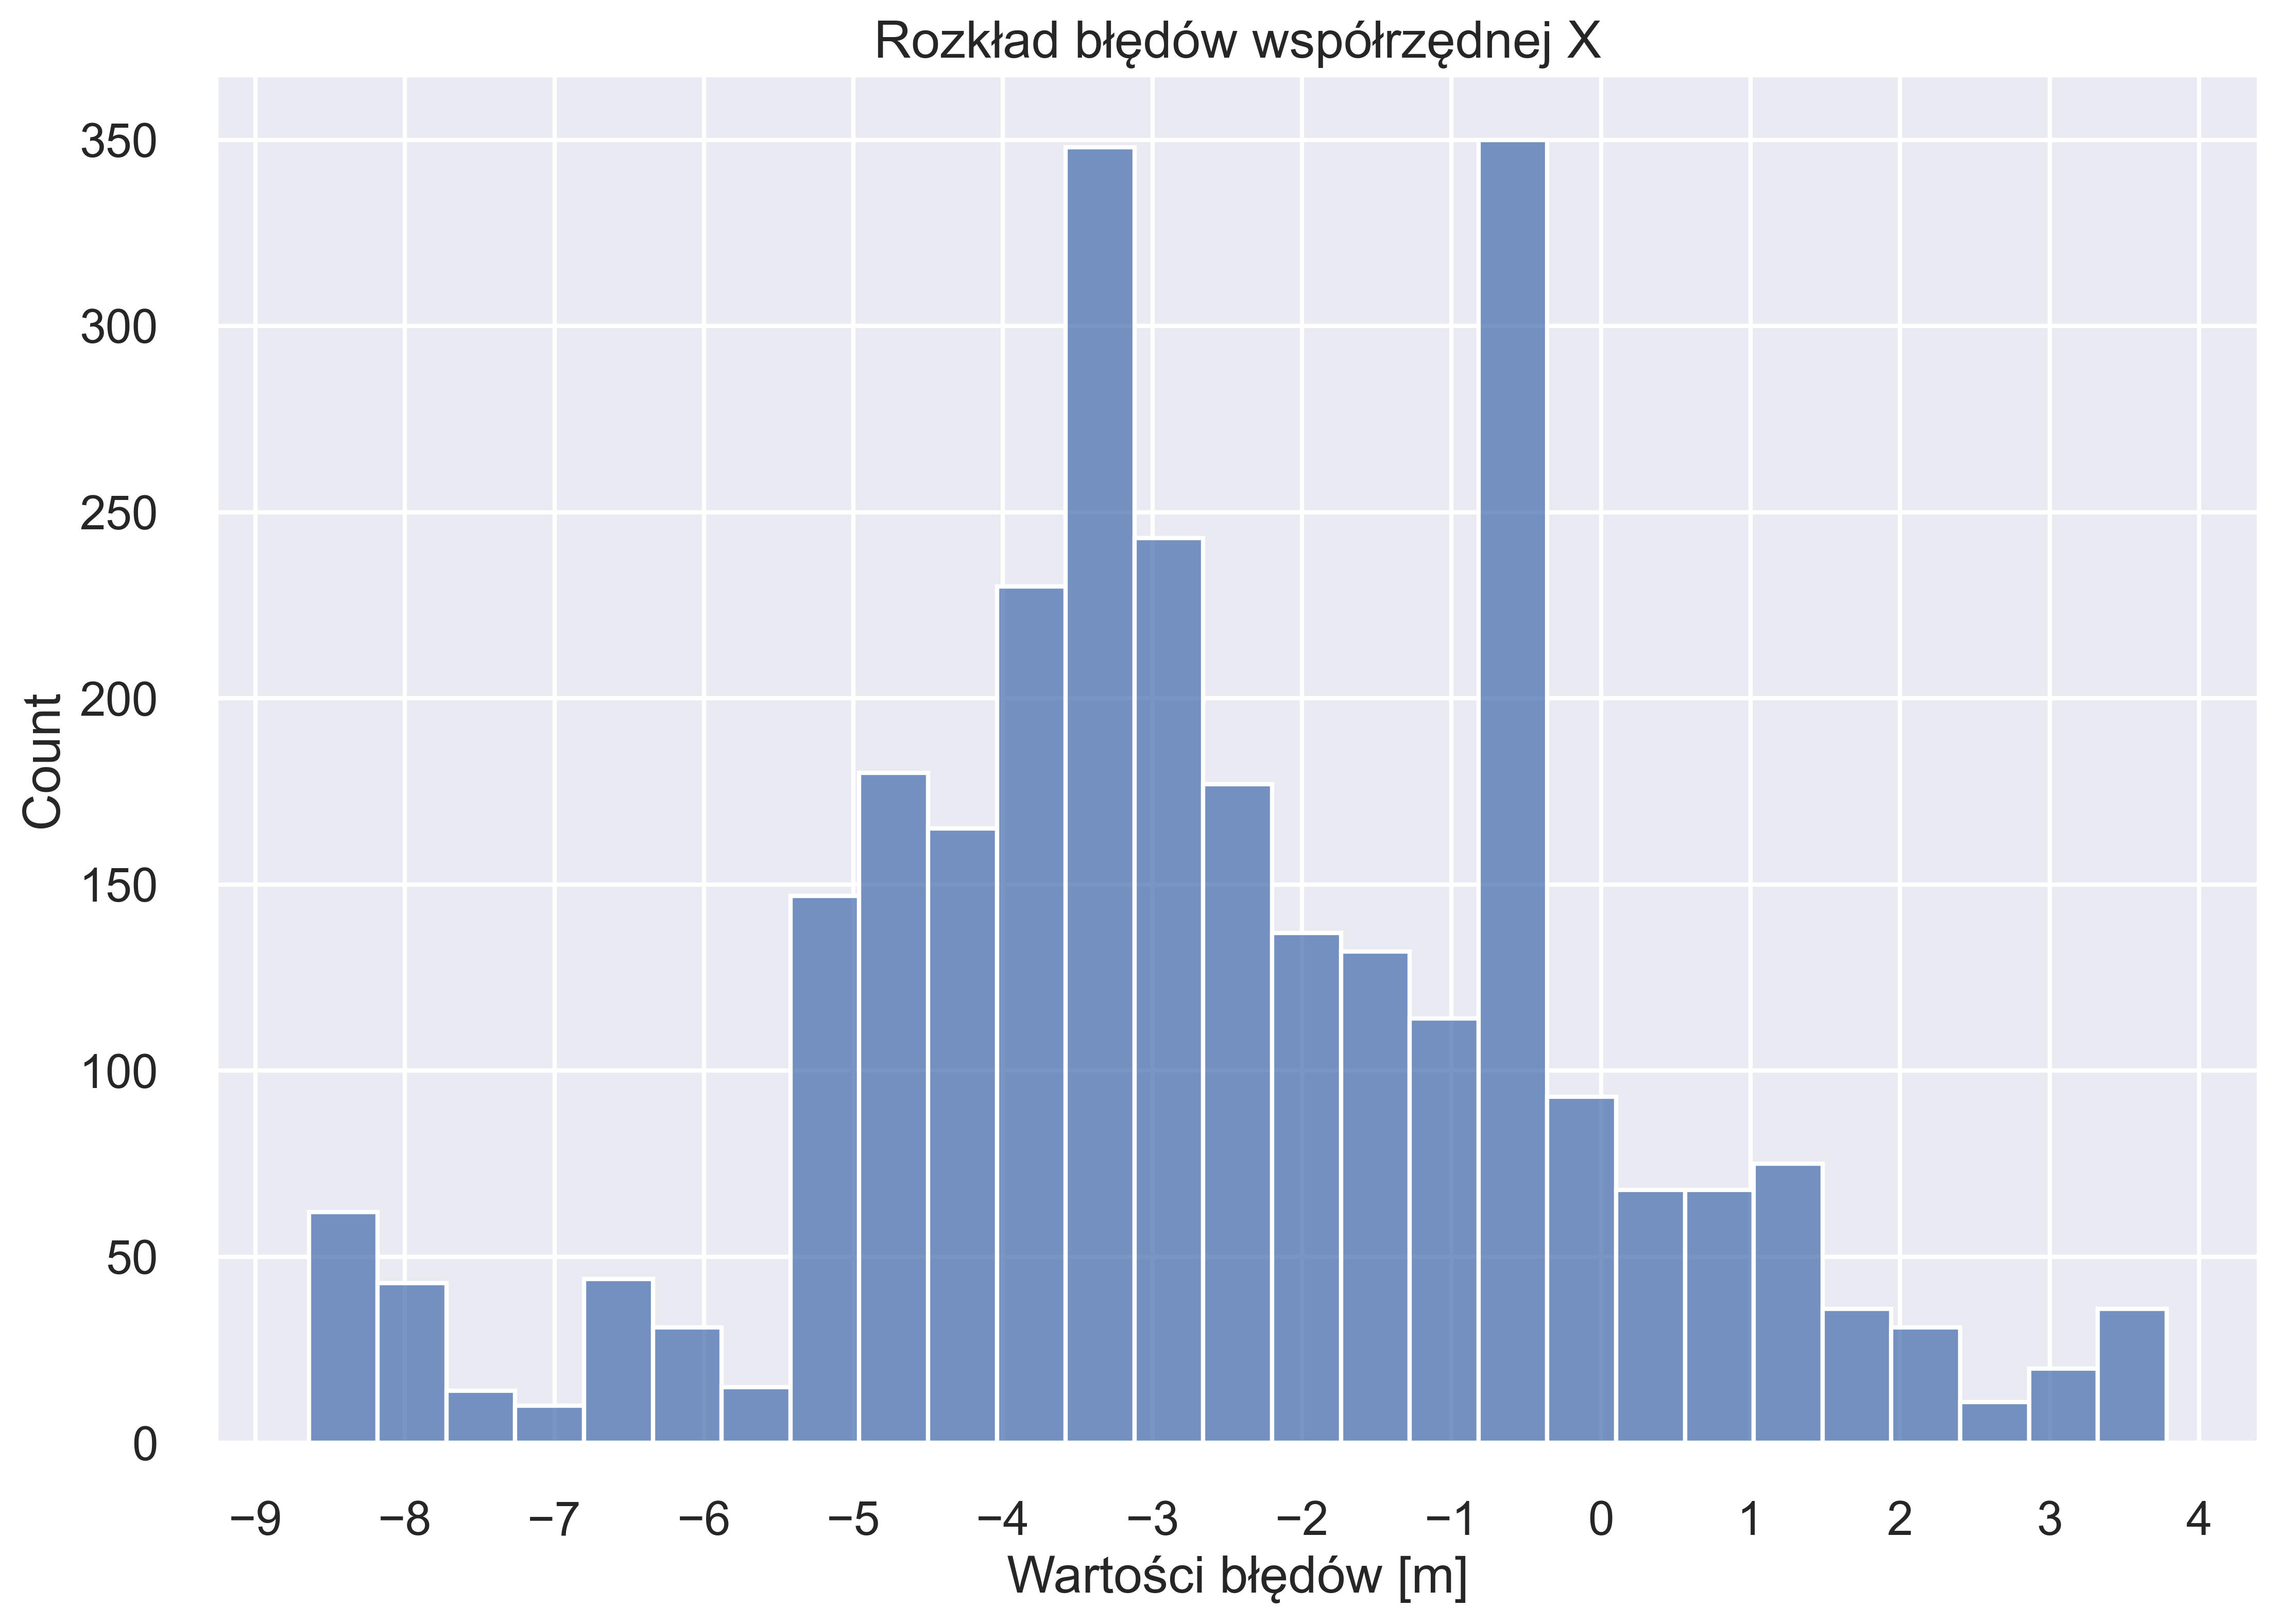

In [171]:
sns.histplot(KONT_DX)
plt.title('Rozkład błędów współrzędnej X')
plt.xlabel('Wartości błędów [m]')
plt.xticks(np.arange(int(min(KONT_DX)-1), int(max(KONT_DX)+2),1))
plt.show()

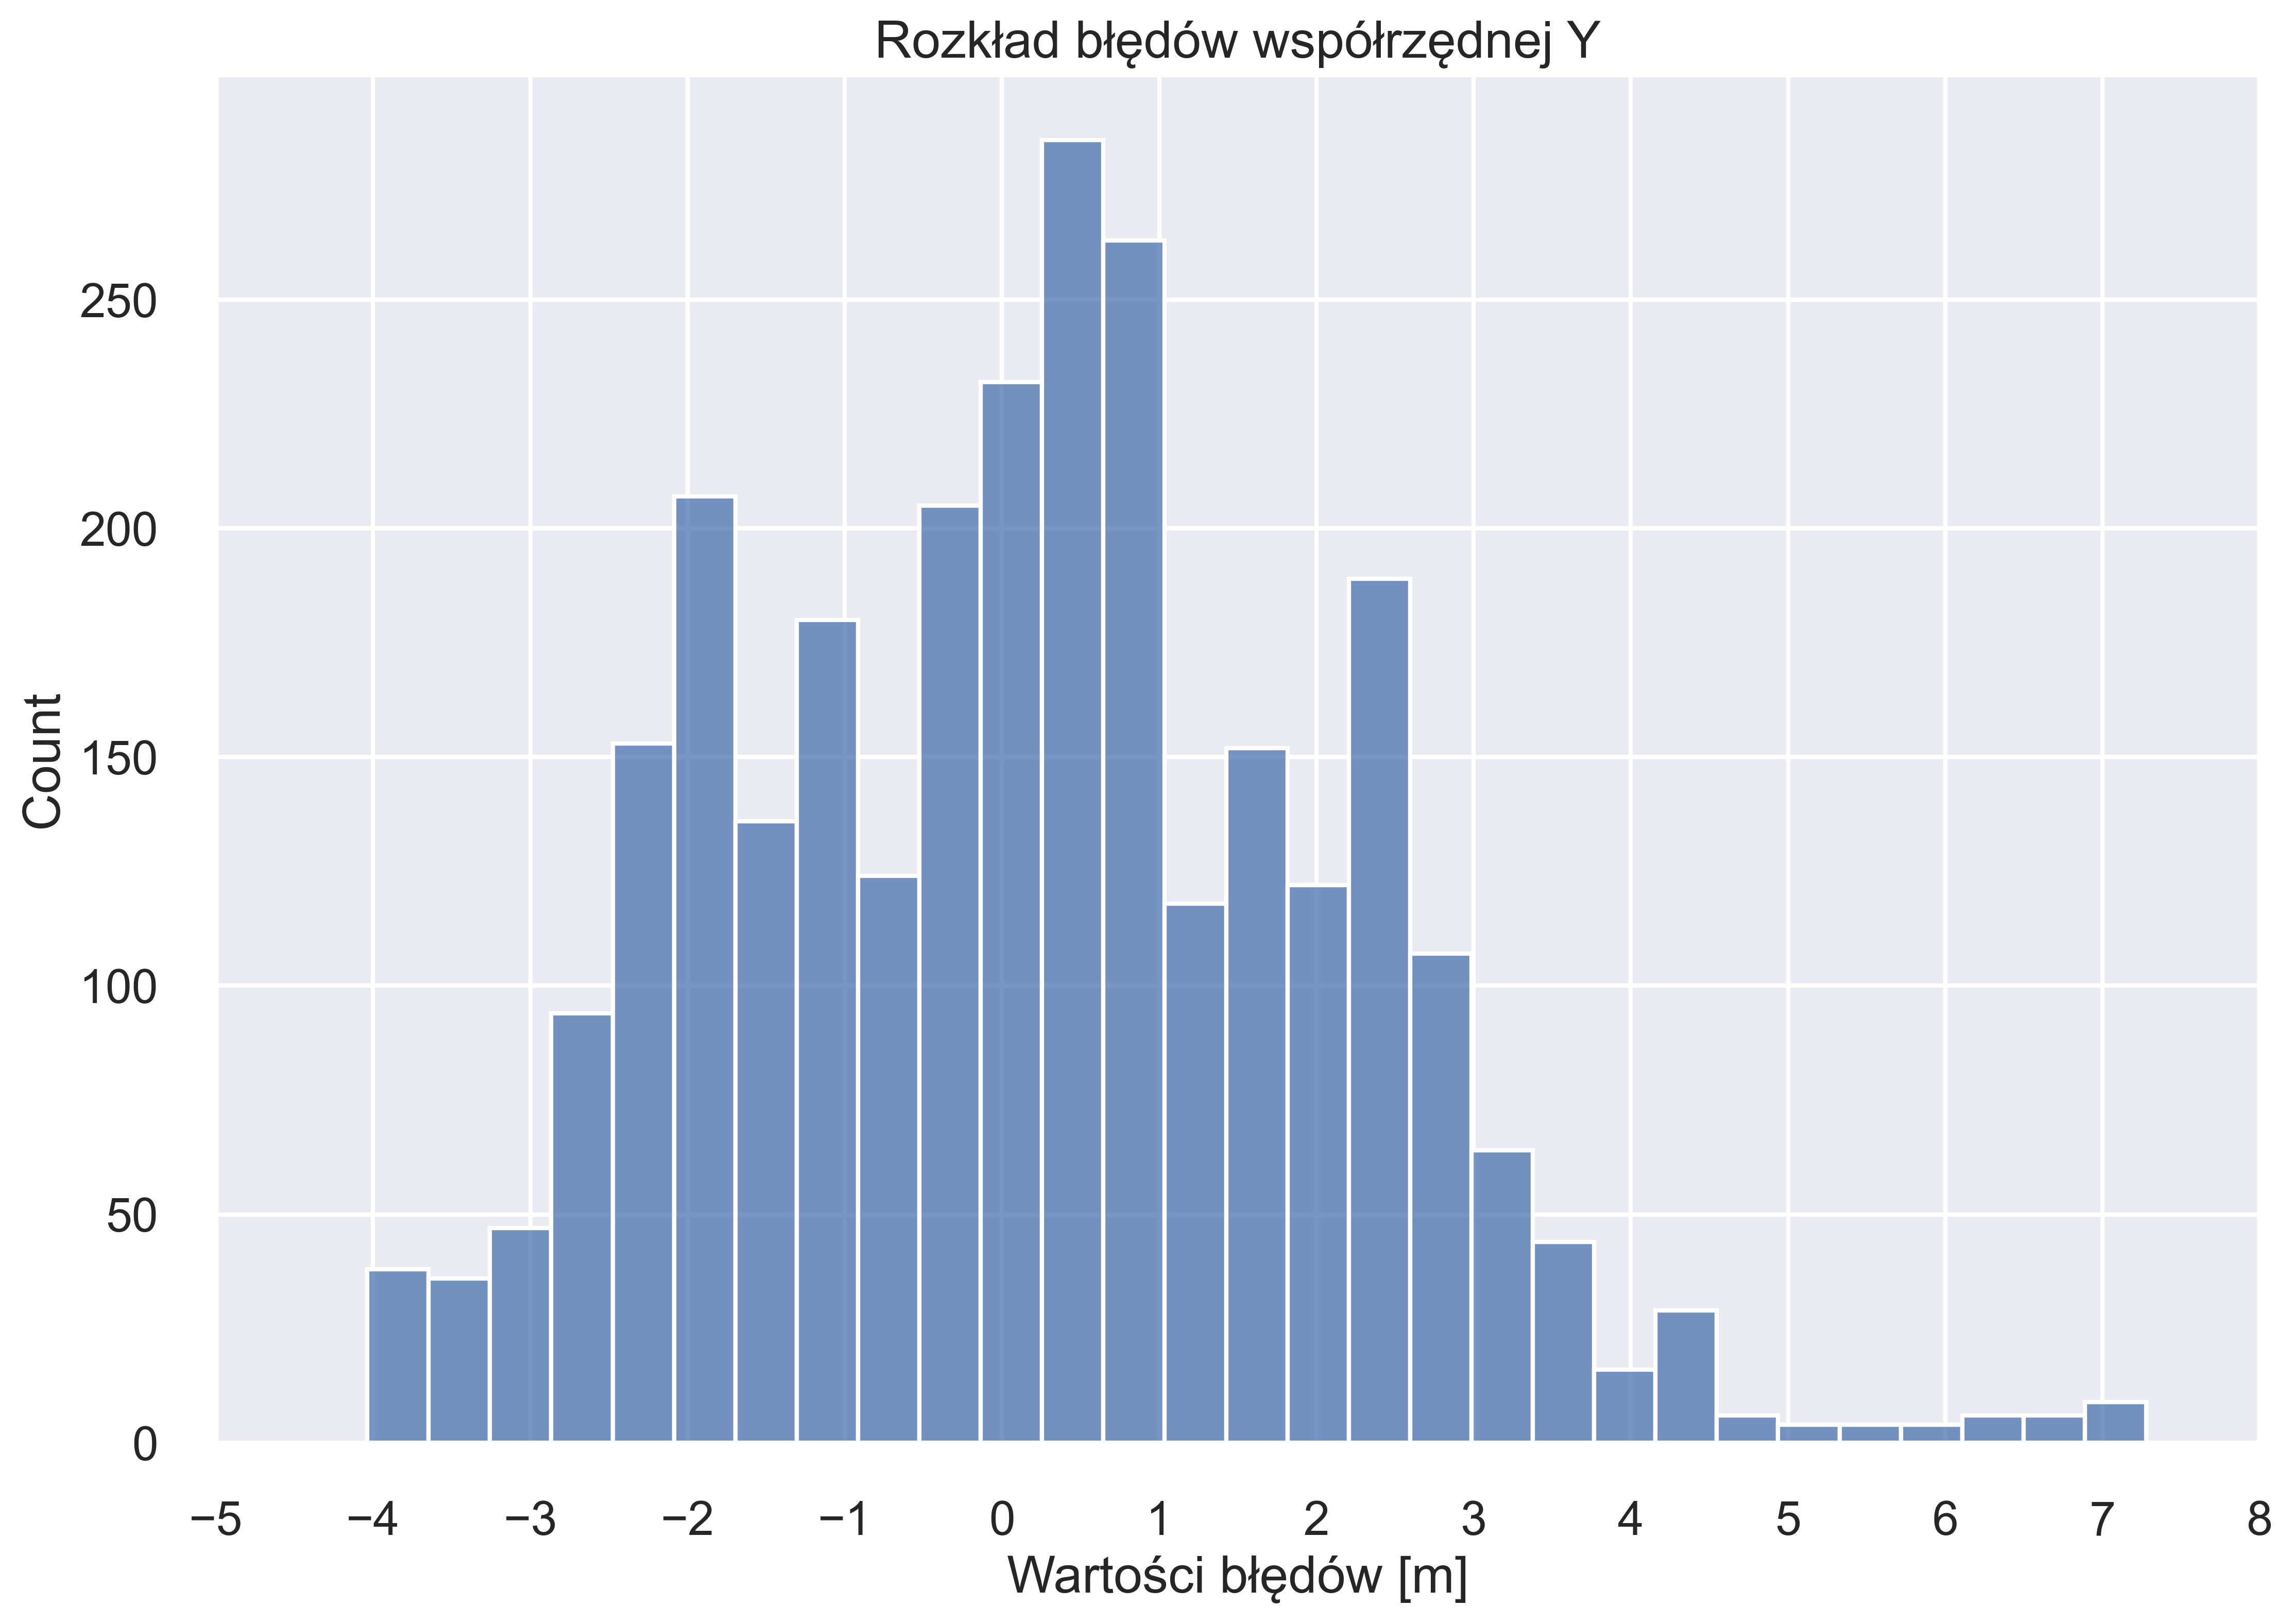

In [172]:
sns.histplot(KONT_DY)
plt.title('Rozkład błędów współrzędnej Y')
plt.xlabel('Wartości błędów [m]')
plt.xticks(np.arange(int(min(KONT_DY)-1), int(max(KONT_DY)+2),1))
plt.show()

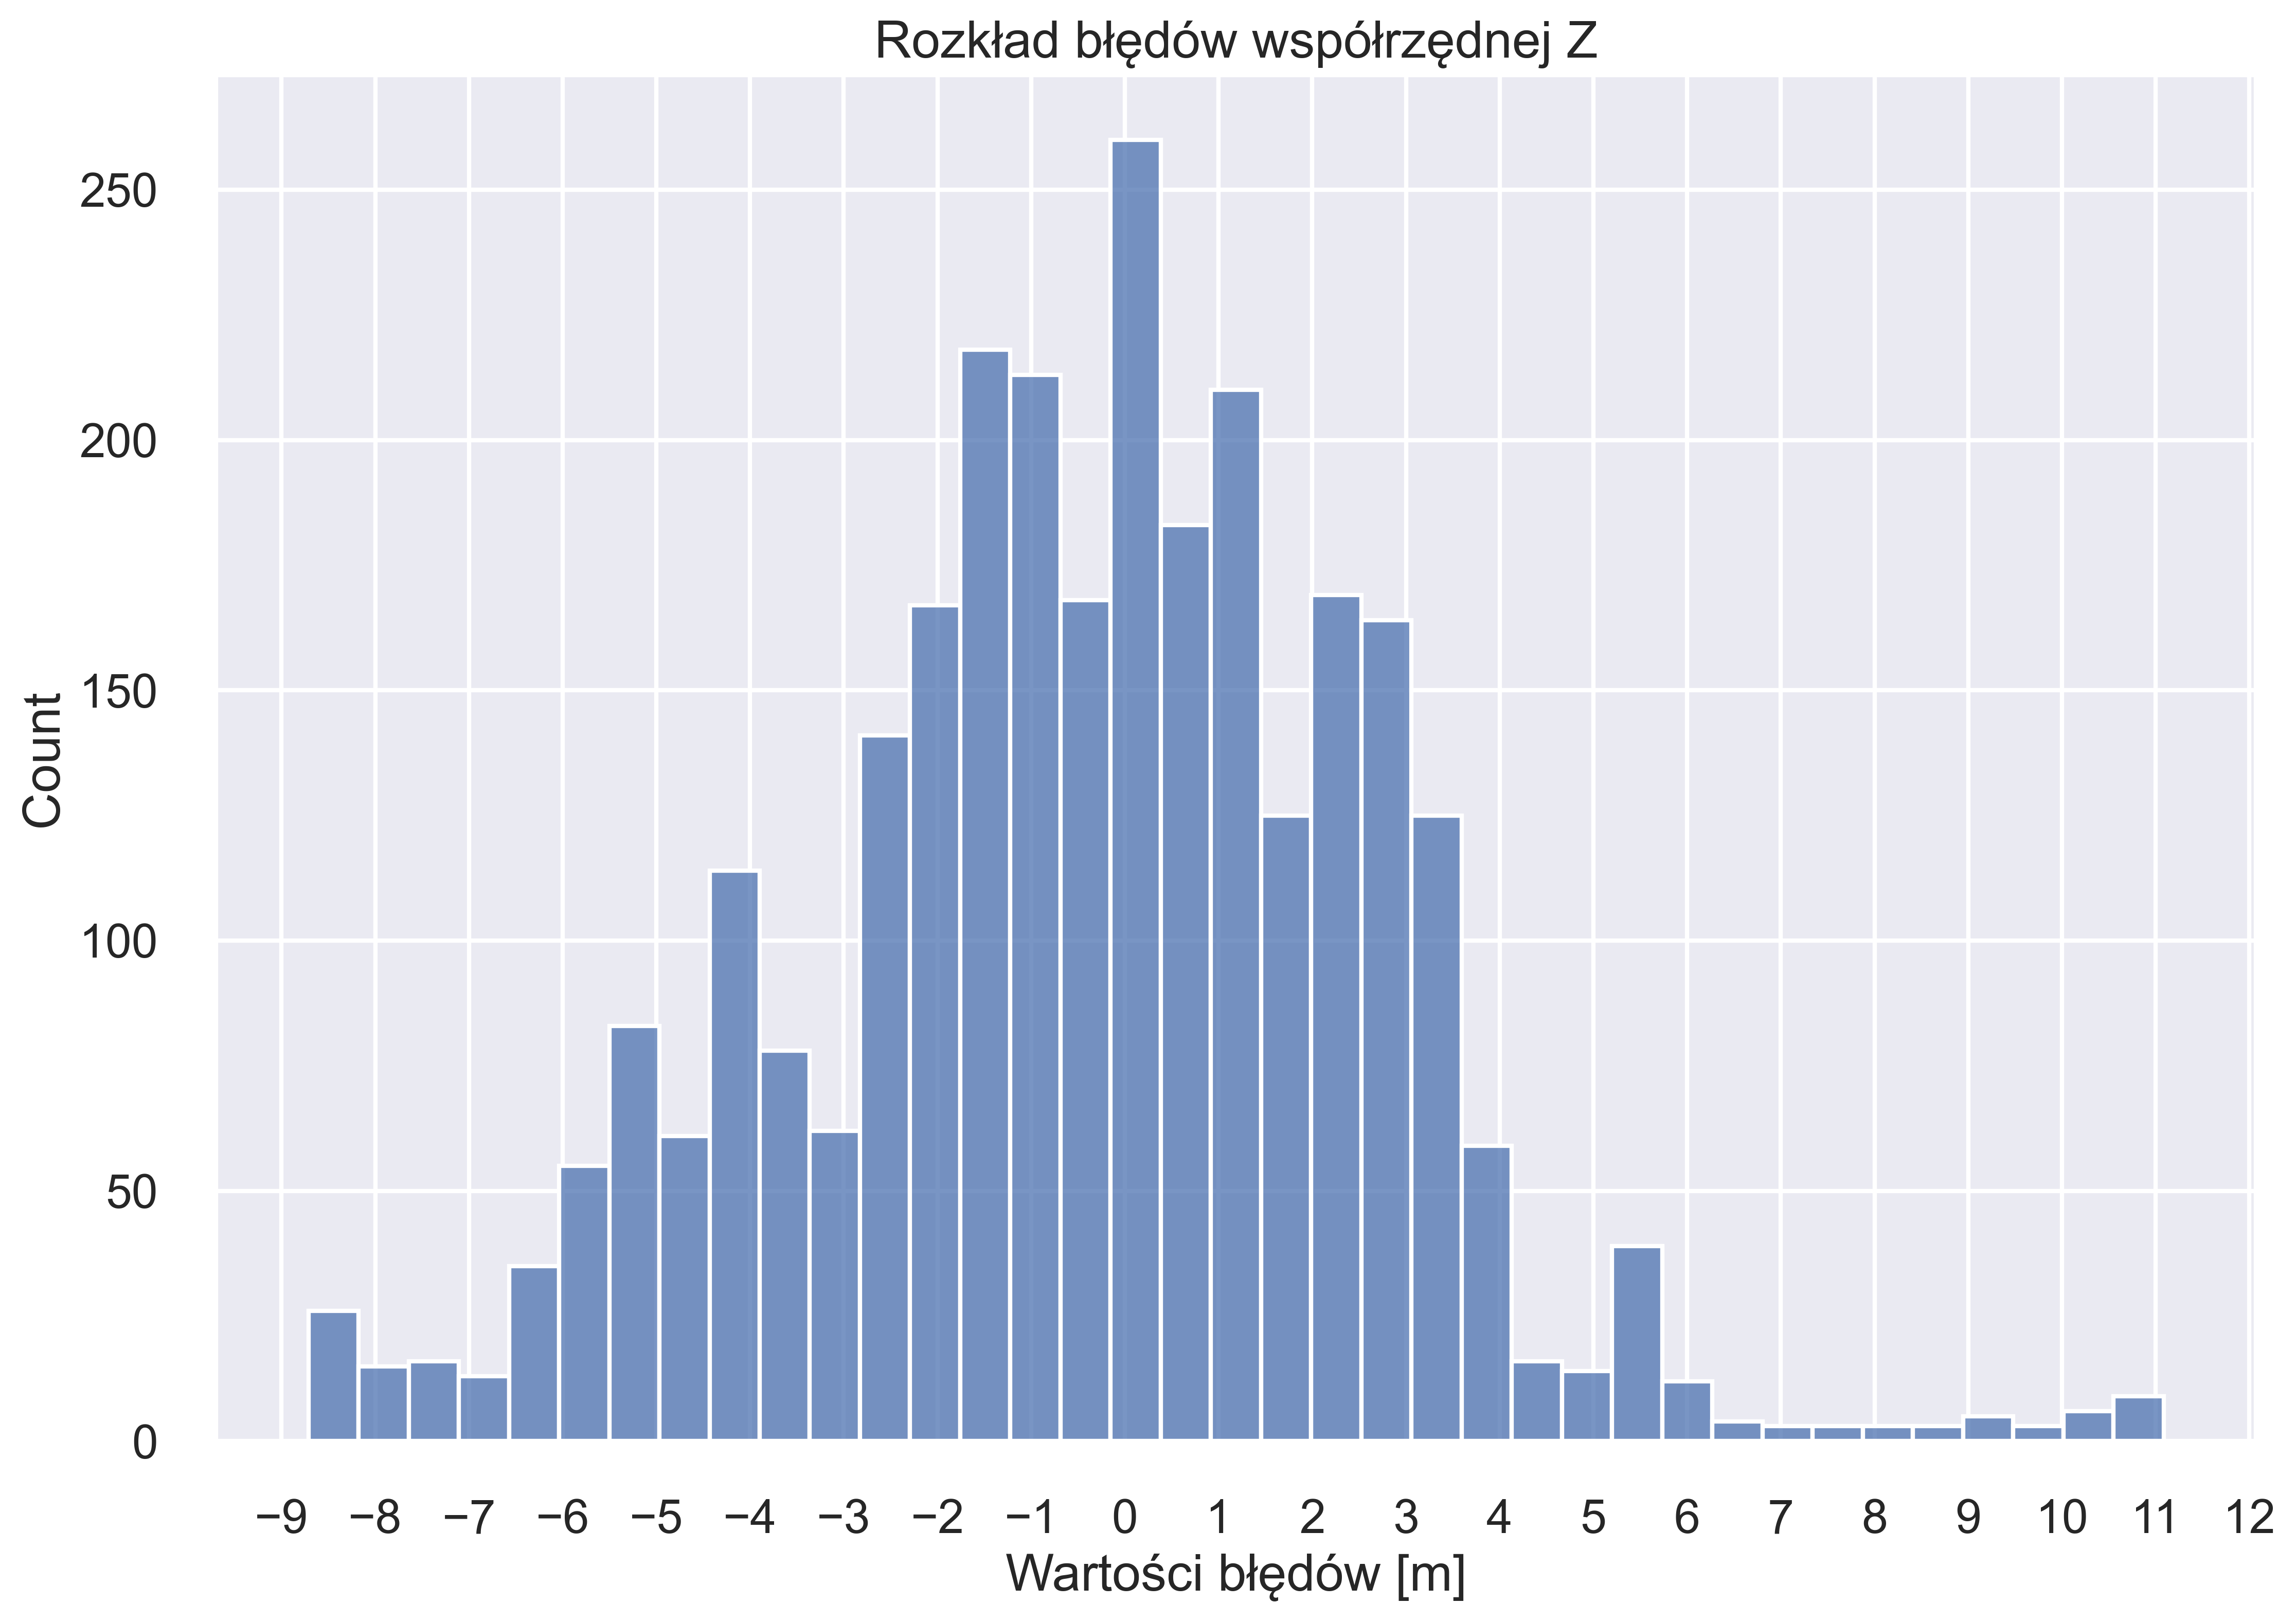

In [173]:
sns.histplot(KONT_DZ)
plt.title('Rozkład błędów współrzędnej Z')
plt.xlabel('Wartości błędów [m]')
plt.xticks(np.arange(int(min(KONT_DZ)-1), int(max(KONT_DZ)+2),1))
plt.show()

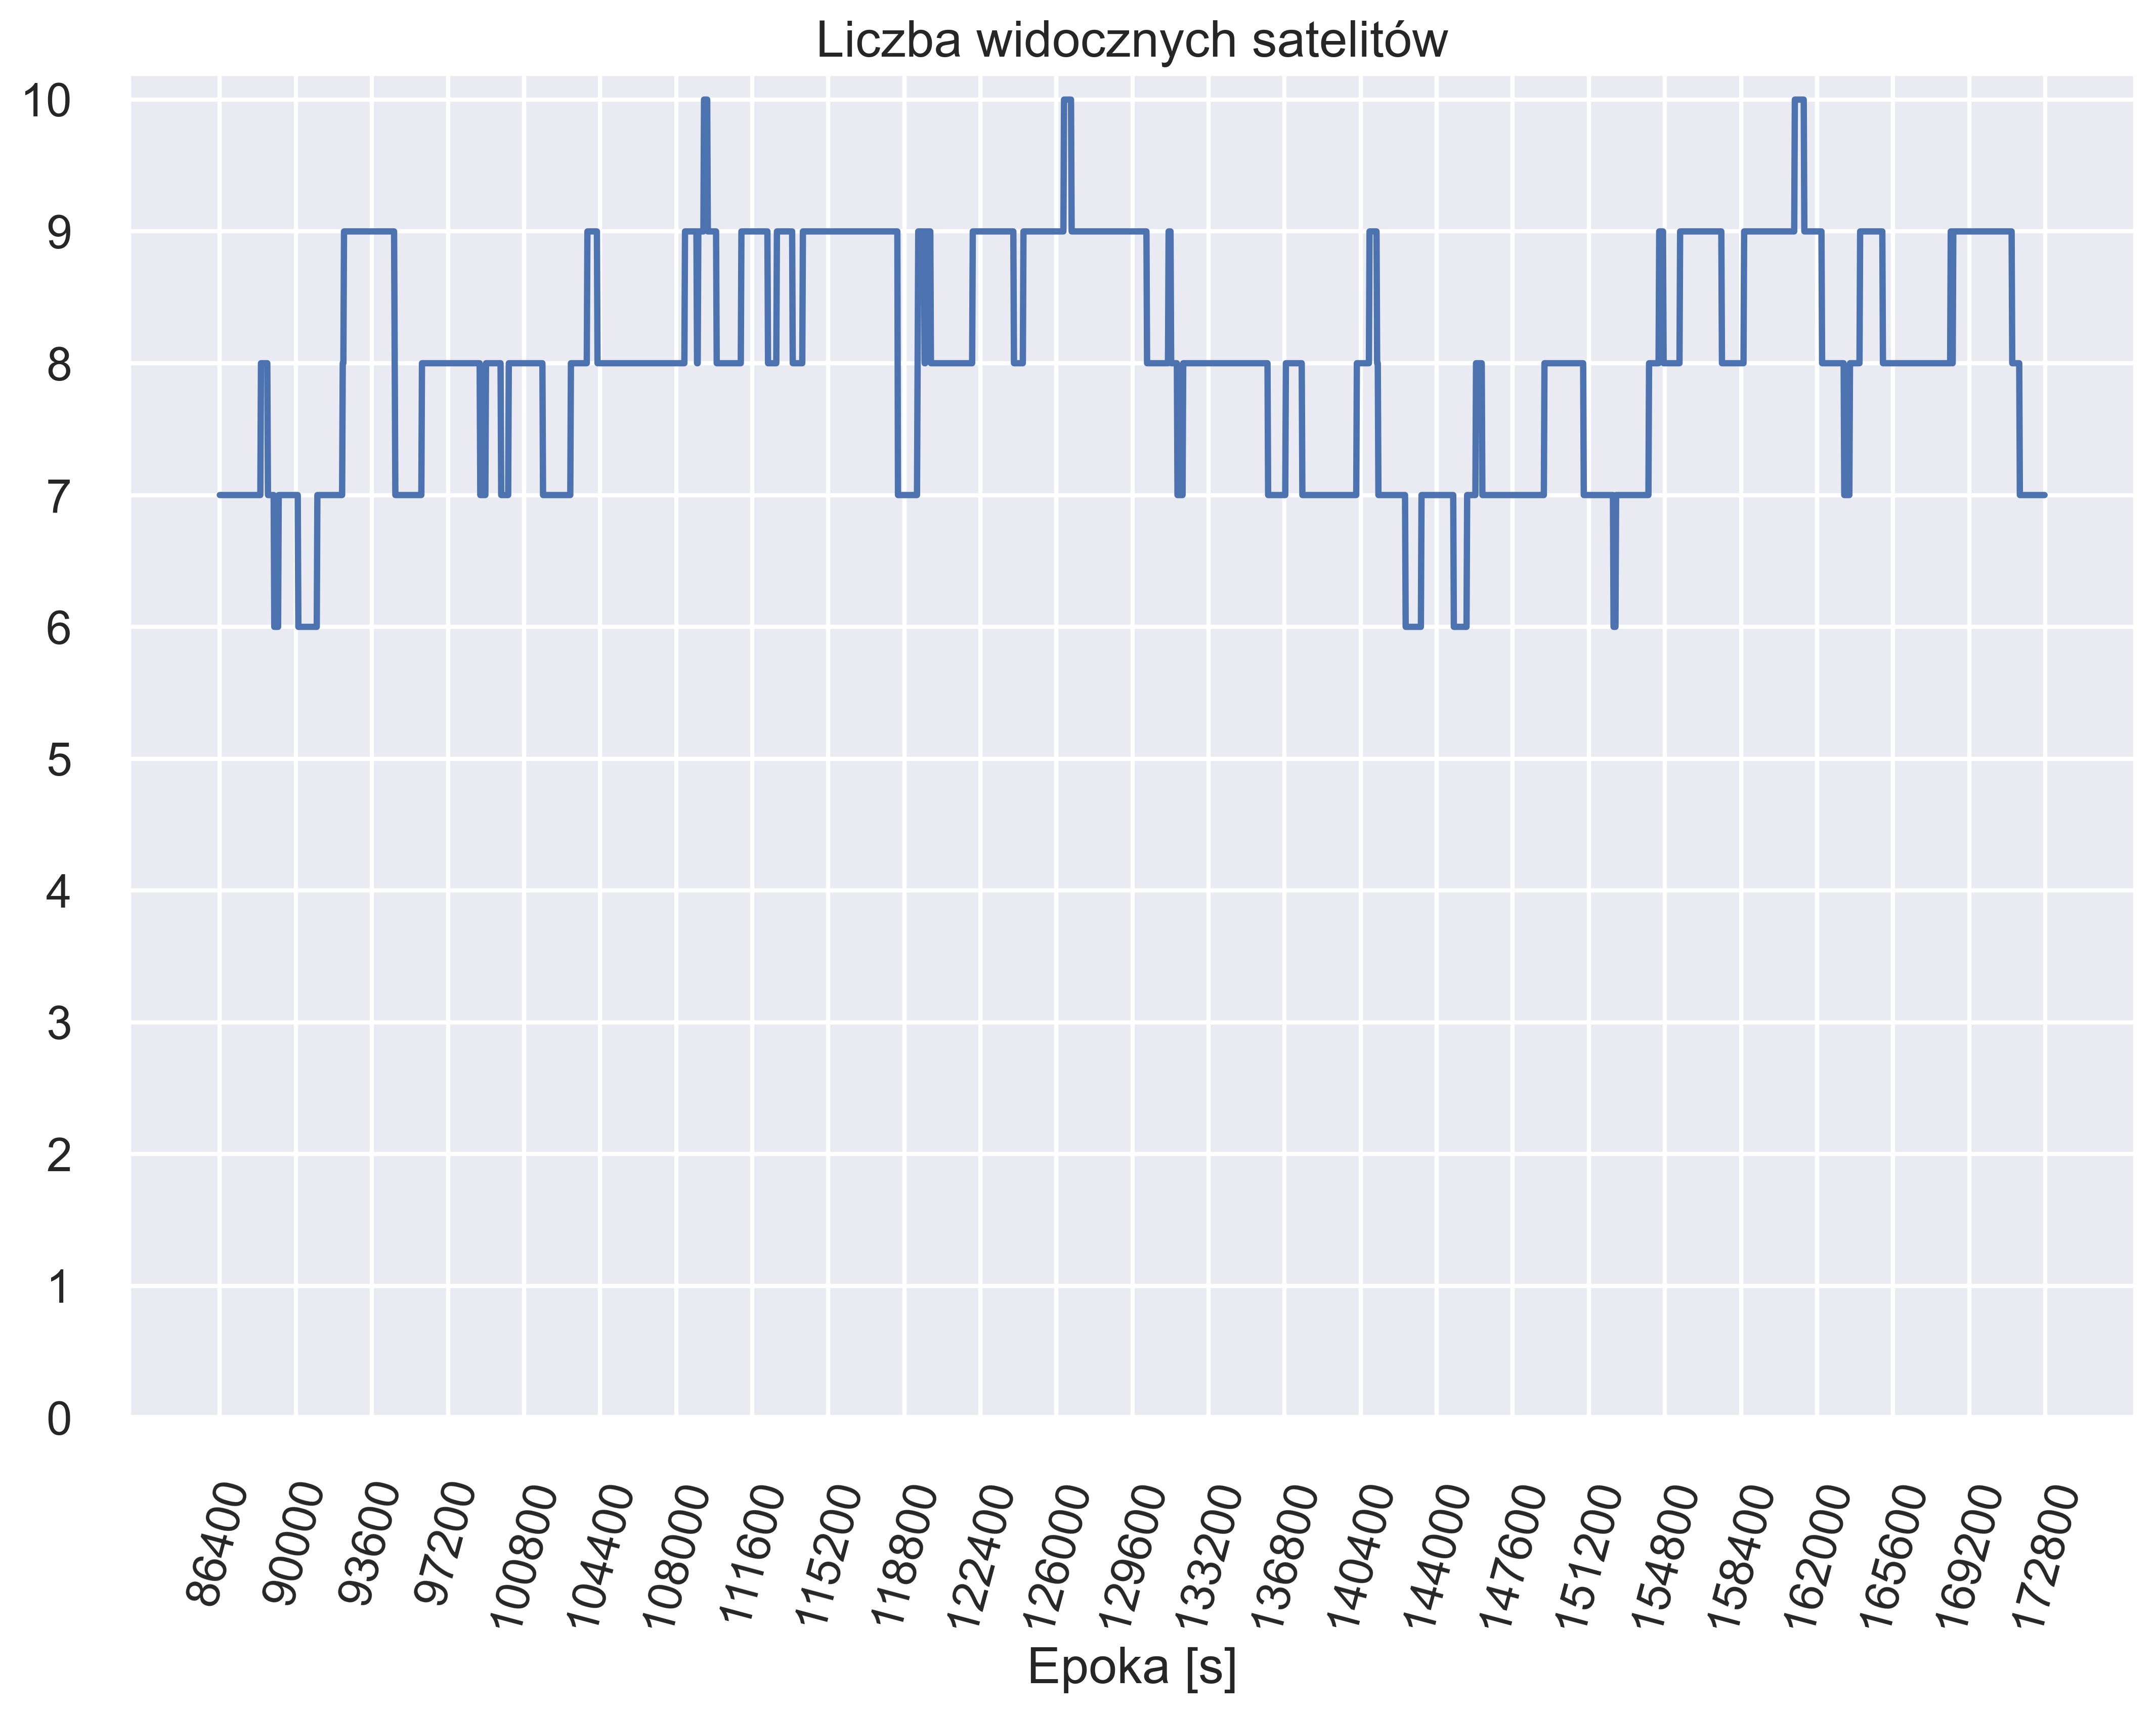

In [174]:
plt.title('Liczba widocznych satelitów')
plt.plot(np.arange(tow, tow_end+1, dt),VISIBLE_SATS)
plt.yticks(np.arange(0,max(VISIBLE_SATS)+1,1))
plt.xticks(np.arange(tow,tow_end+3600,3600), rotation=75)
plt.xlabel('Epoka [s]')
plt.show()